#Import Libraries dan Setup

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, confusion_matrix,
                           classification_report)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

# Setup untuk performance cepat
tf.config.experimental.enable_memory_growth = True
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.18.0
GPU available: []


#Load Data dan Exploration

In [11]:
# Load CIFAR-10 dataset
(X_train_full, y_train_full), (X_test_full, y_test_full) = keras.datasets.cifar10.load_data()

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Create subset untuk training cepat
subset_size = 5000
test_size = 1000

# Stratified sampling
indices_train = []
indices_test = []

for class_id in range(10):
    class_indices_train = np.where(y_train_full.flatten() == class_id)[0]
    class_indices_test = np.where(y_test_full.flatten() == class_id)[0]

    indices_train.extend(np.random.choice(class_indices_train,
                                        size=min(subset_size//10, len(class_indices_train)),
                                        replace=False))
    indices_test.extend(np.random.choice(class_indices_test,
                                       size=min(test_size//10, len(class_indices_test)),
                                       replace=False))

X_train = X_train_full[indices_train]
y_train = y_train_full[indices_train]
X_test = X_test_full[indices_test]
y_test = y_test_full[indices_test]

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Classes: {class_names}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training set: (5000, 32, 32, 3)
Test set: (1000, 32, 32, 3)
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


#Data Visualization

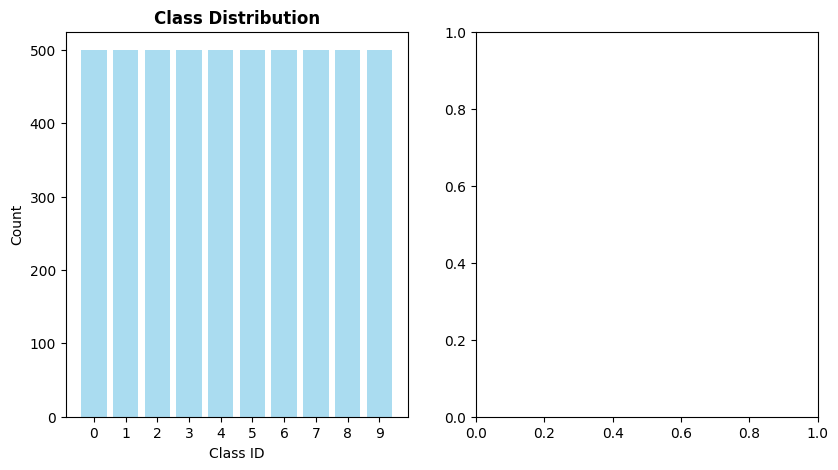

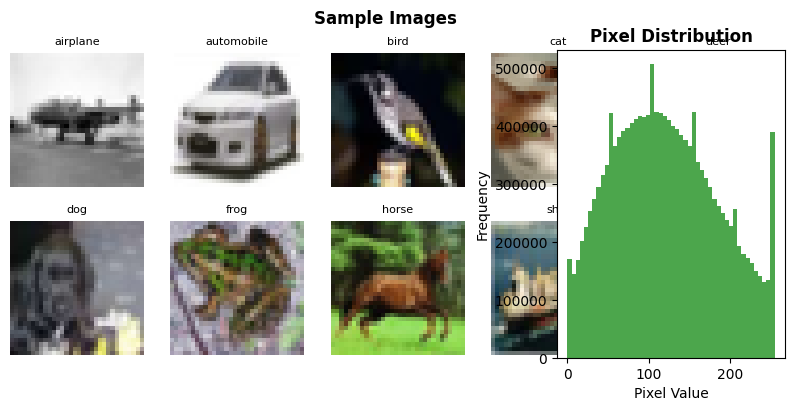

Data Statistics:
Pixel range: [0, 255]
Mean: 120.70, Std: 64.07


In [12]:
# Data exploration
plt.figure(figsize=(15, 5))

# Class distribution
plt.subplot(1, 3, 1)
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts, color='skyblue', alpha=0.7)
plt.title('Class Distribution', fontweight='bold')
plt.xlabel('Class ID')
plt.ylabel('Count')
plt.xticks(range(10))

# Sample images
plt.subplot(1, 3, 2)
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(10):
    idx = np.where(y_train == i)[0][0]
    ax = axes[i//5, i%5]
    ax.imshow(X_train[idx])
    ax.set_title(f'{class_names[i]}', fontsize=8)
    ax.axis('off')
plt.suptitle('Sample Images', fontweight='bold')

# Pixel distribution
plt.subplot(1, 3, 3)
plt.hist(X_train.flatten(), bins=50, alpha=0.7, color='green')
plt.title('Pixel Distribution', fontweight='bold')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Data Statistics:")
print(f"Pixel range: [{X_train.min()}, {X_train.max()}]")
print(f"Mean: {X_train.mean():.2f}, Std: {X_train.std():.2f}")

#Data Preprocessing

Normalized pixel range: [0.000, 1.000]
Label encoding shape: (5000, 10)


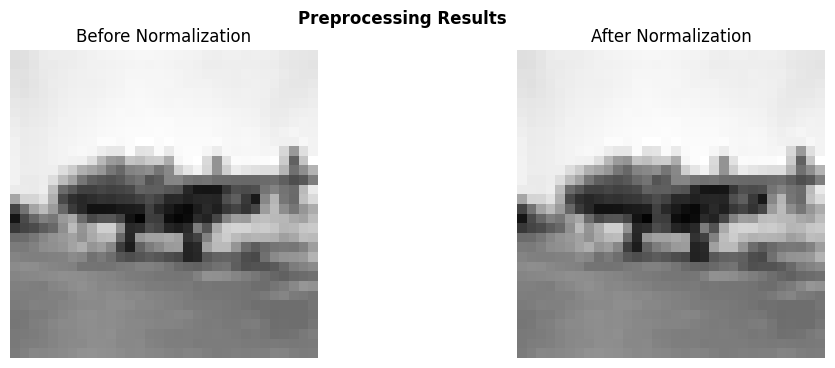

In [13]:
# Normalisasi pixel values
X_train_norm = X_train.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# Flatten dan encode labels
y_train_flat = y_train.flatten()
y_test_flat = y_test.flatten()
y_train_encoded = to_categorical(y_train_flat, 10)
y_test_encoded = to_categorical(y_test_flat, 10)

print(f"Normalized pixel range: [{X_train_norm.min():.3f}, {X_train_norm.max():.3f}]")
print(f"Label encoding shape: {y_train_encoded.shape}")

# Show before/after preprocessing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.imshow(X_train[0])
ax1.set_title('Before Normalization')
ax1.axis('off')

ax2.imshow(X_train_norm[0])
ax2.set_title('After Normalization')
ax2.axis('off')

plt.suptitle('Preprocessing Results', fontweight='bold')
plt.show()

# Membuat Model CNN

Total parameters: 315,722


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,722 (1.20 MB)

 Trainable params: 315,722 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

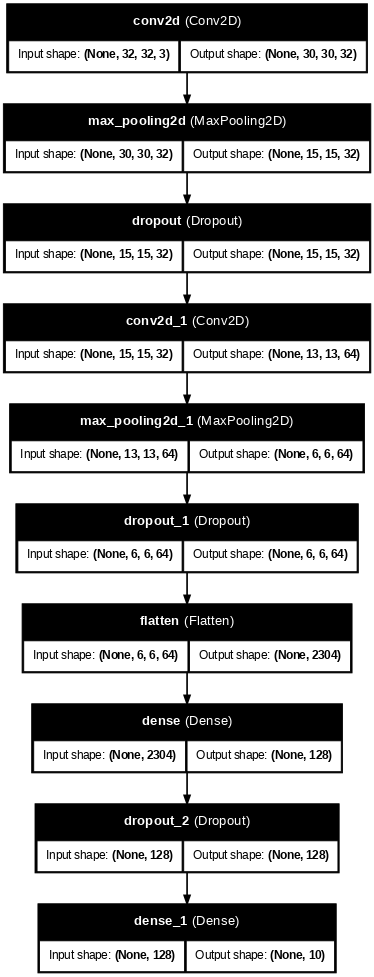

In [14]:
def build_fast_cnn():
    model = keras.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Classifier
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Build model
model = build_fast_cnn()

print(f"Total parameters: {model.count_params():,}")

# Model summary
model.summary()

# Visualize model architecture
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, dpi=60)

# Train Model

In [15]:
# Setup callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        patience=3,
        restore_best_weights=True,
        monitor='val_accuracy',
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=2,
        monitor='val_loss',
        verbose=1
    )
]

# Train model
history = model.fit(
    X_train_norm, y_train_encoded,
    batch_size=128,
    epochs=15,
    validation_data=(X_test_norm, y_test_encoded),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 215ms/step - accuracy: 0.1112 - loss: 2.3697 - val_accuracy: 0.2420 - val_loss: 2.1280 - learning_rate: 0.0100
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - accuracy: 0.2212 - loss: 2.1193 - val_accuracy: 0.2790 - val_loss: 2.0242 - learning_rate: 0.0100
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.2340 - loss: 2.0669 - val_accuracy: 0.2770 - val_loss: 2.0201 - learning_rate: 0.0100
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.2501 - loss: 2.0409 - val_accuracy: 0.2870 - val_loss: 2.0090 - learning_rate: 0.0100
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 192ms/step - accuracy: 0.2538 - loss: 2.0342 - val_accuracy: 0.2780 - val_loss: 1.9291 - learning_rate: 0.0100
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.2748 - loss: 1.9872 - val_accuracy: 0.3040 - val_loss: 1.9084 - learning_rate: 0.0100
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.2791 - loss: 1.930

#Visualization

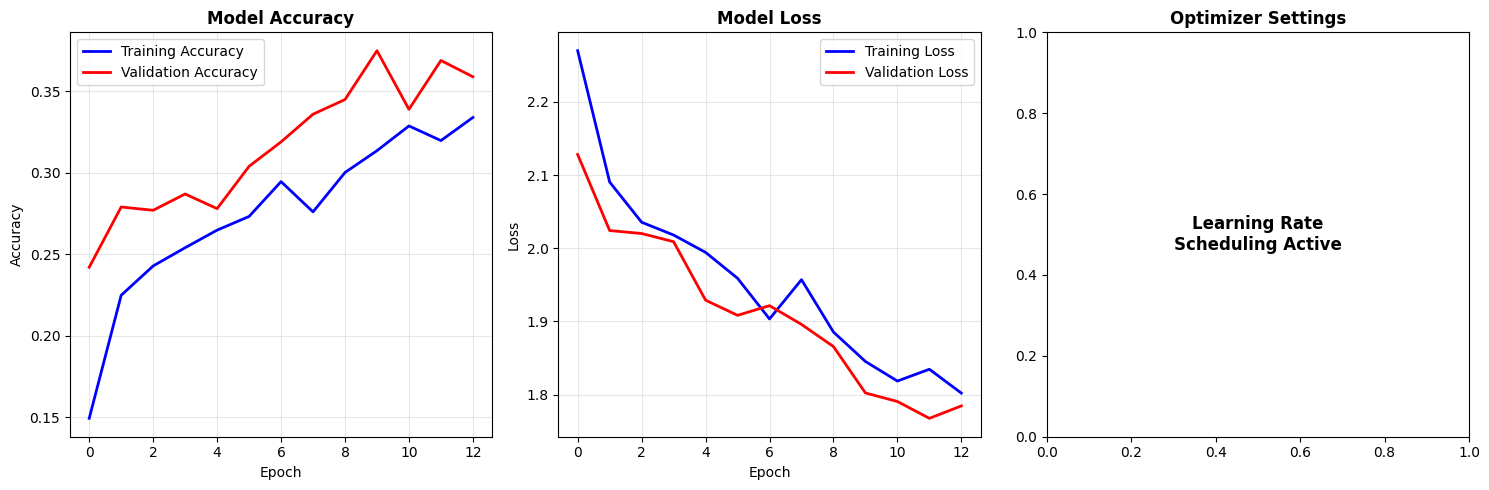

In [17]:
# Plot training history
plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning rate (if available)
plt.subplot(1, 3, 3)
if 'lr' in history.history:
    plt.plot(history.history['lr'], 'g-', linewidth=2)
    plt.title('Learning Rate', fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
else:
    plt.text(0.5, 0.5, 'Learning Rate\nScheduling Active',
             ha='center', va='center', fontsize=12, fontweight='bold')
    plt.title('Optimizer Settings', fontweight='bold')

plt.tight_layout()
plt.show()

#Model Evaluation

In [18]:
# Make predictions
y_pred_proba = model.predict(X_test_norm, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate all metrics
accuracy = accuracy_score(y_test_flat, y_pred)
precision = precision_score(y_test_flat, y_pred, average='weighted')
recall = recall_score(y_test_flat, y_pred, average='weighted')
f1 = f1_score(y_test_flat, y_pred, average='weighted')
auc_roc = roc_auc_score(y_test_encoded, y_pred_proba, average='weighted', multi_class='ovr')

# Print results
print("="*60)
print("EVALUATION RESULTS")
print("="*60)
print(f"Accuracy:  {accuracy:.4f} ({'Excellent' if accuracy > 0.8 else 'Good' if accuracy > 0.7 else 'Fair'})")
print(f"Precision: {precision:.4f} ({'Excellent' if precision > 0.8 else 'Good' if precision > 0.7 else 'Fair'})")
print(f"Recall:    {recall:.4f} ({'Excellent' if recall > 0.8 else 'Good' if recall > 0.7 else 'Fair'})")
print(f"F1-Score:  {f1:.4f} ({'Excellent' if f1 > 0.8 else 'Good' if f1 > 0.7 else 'Fair'})")
print(f"AUC-ROC:   {auc_roc:.4f} ({'Excellent' if auc_roc > 0.85 else 'Good' if auc_roc > 0.75 else 'Fair'})")

# Store metrics for analysis
metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'auc_roc': auc_roc
}

EVALUATION RESULTS
Accuracy:  0.3750 (Fair)
Precision: 0.4068 (Fair)
Recall:    0.3750 (Fair)
F1-Score:  0.3595 (Fair)
AUC-ROC:   0.8071 (Good)


#Comprehensive Visualization

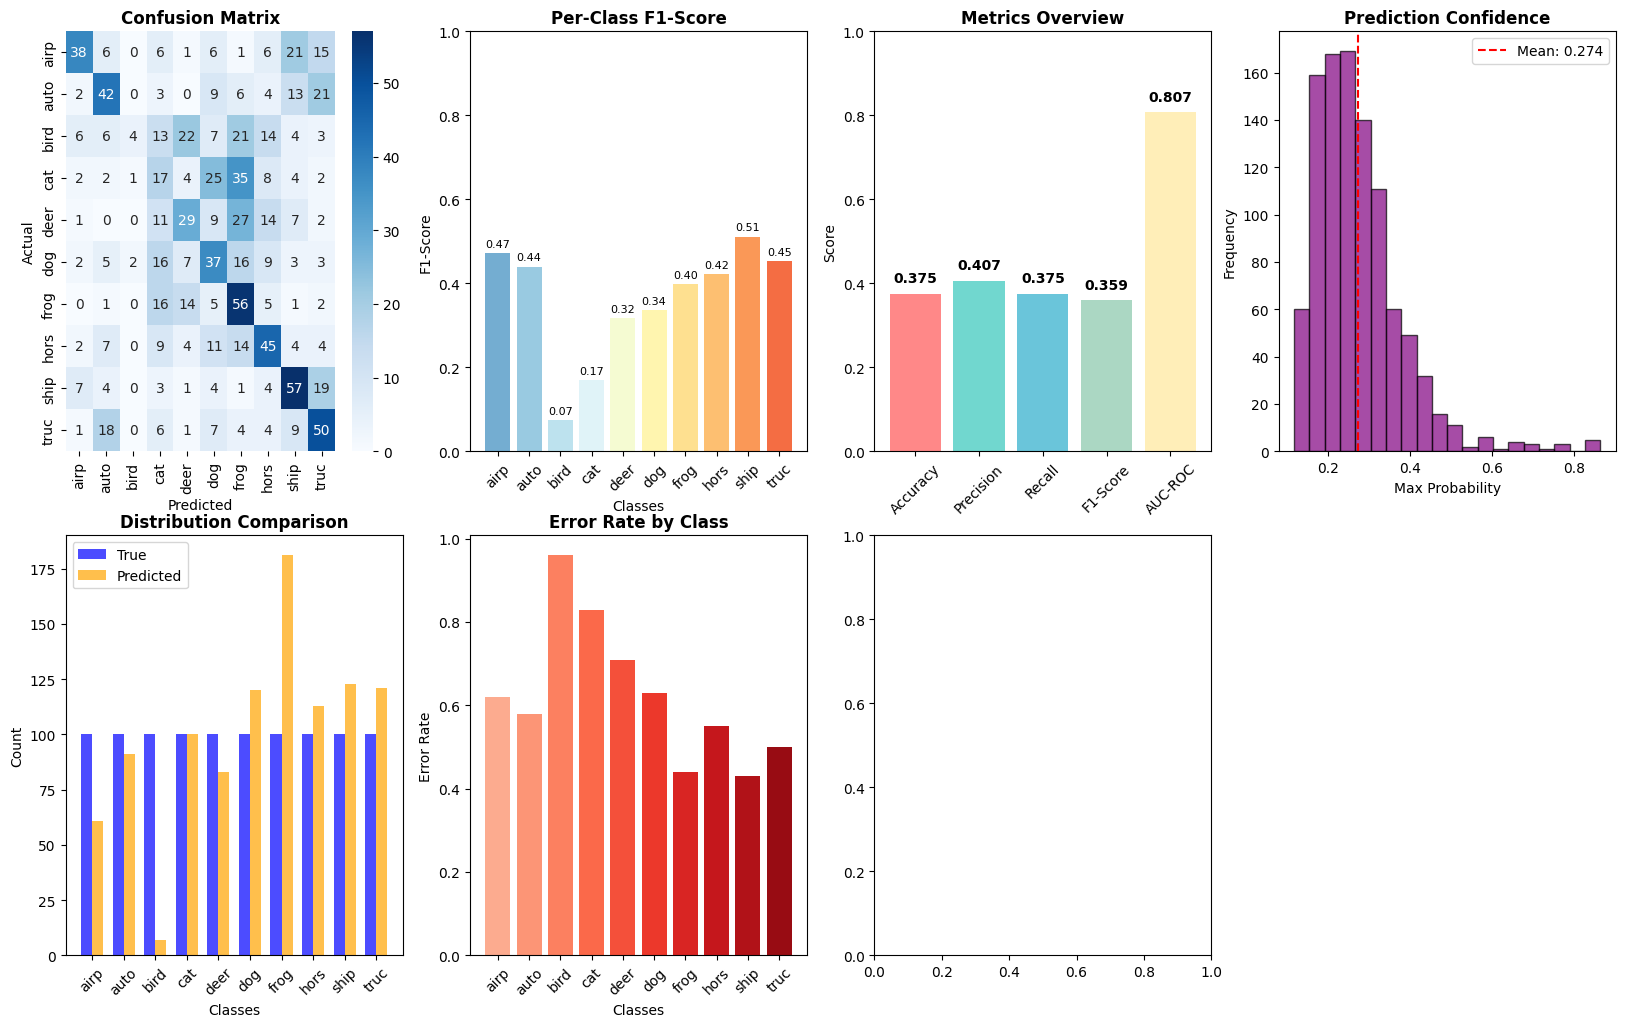

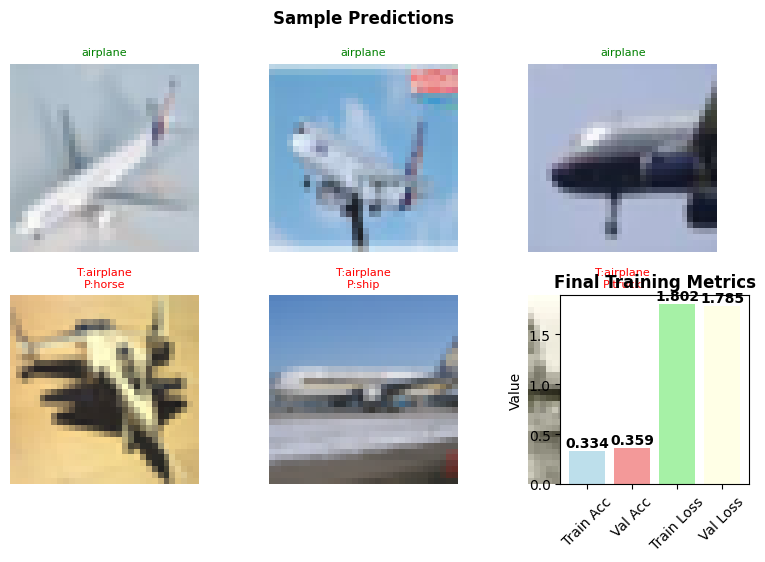

In [19]:
# Create comprehensive visualization
plt.figure(figsize=(20, 12))

# 1. Confusion Matrix
plt.subplot(2, 4, 1)
cm = confusion_matrix(y_test_flat, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
           xticklabels=[name[:4] for name in class_names],
           yticklabels=[name[:4] for name in class_names])
plt.title('Confusion Matrix', fontweight='bold', fontsize=12)
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 2. Per-class Performance
plt.subplot(2, 4, 2)
report = classification_report(y_test_flat, y_pred, target_names=class_names, output_dict=True)
per_class_f1 = [report[class_name]['f1-score'] for class_name in class_names]
colors = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(class_names)))
bars = plt.bar(range(len(class_names)), per_class_f1, color=colors)
plt.title('Per-Class F1-Score', fontweight='bold')
plt.xlabel('Classes')
plt.ylabel('F1-Score')
plt.xticks(range(len(class_names)), [name[:4] for name in class_names], rotation=45)
plt.ylim(0, 1)

# Add value labels
for bar, value in zip(bars, per_class_f1):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{value:.2f}', ha='center', va='bottom', fontsize=8)

# 3. Metrics Comparison
plt.subplot(2, 4, 3)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
metrics_values = list(metrics.values())
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
bars = plt.bar(metrics_names, metrics_values, color=colors, alpha=0.8)
plt.title('Metrics Overview', fontweight='bold')
plt.ylabel('Score')
plt.ylim(0, 1)

# Add value labels
for bar, value in zip(bars, metrics_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45)

# 4. Prediction Confidence Distribution
plt.subplot(2, 4, 4)
max_probs = np.max(y_pred_proba, axis=1)
plt.hist(max_probs, bins=20, alpha=0.7, color='purple', edgecolor='black')
plt.title('Prediction Confidence', fontweight='bold')
plt.xlabel('Max Probability')
plt.ylabel('Frequency')
plt.axvline(np.mean(max_probs), color='red', linestyle='--',
           label=f'Mean: {np.mean(max_probs):.3f}')
plt.legend()

# 5. True vs Predicted Distribution
plt.subplot(2, 4, 5)
x = np.arange(len(class_names))
true_counts = np.bincount(y_test_flat, minlength=10)
pred_counts = np.bincount(y_pred, minlength=10)

width = 0.35
plt.bar(x - width/2, true_counts, width, label='True', alpha=0.7, color='blue')
plt.bar(x + width/2, pred_counts, width, label='Predicted', alpha=0.7, color='orange')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Distribution Comparison', fontweight='bold')
plt.xticks(x, [name[:4] for name in class_names], rotation=45)
plt.legend()

# 6. Error Analysis
plt.subplot(2, 4, 6)
errors = (y_test_flat != y_pred)
error_by_class = []
for i in range(10):
    class_mask = (y_test_flat == i)
    if np.sum(class_mask) > 0:
        error_rate = np.sum(errors[class_mask]) / np.sum(class_mask)
        error_by_class.append(error_rate)
    else:
        error_by_class.append(0)

colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(class_names)))
bars = plt.bar(range(len(class_names)), error_by_class, color=colors)
plt.xlabel('Classes')
plt.ylabel('Error Rate')
plt.title('Error Rate by Class', fontweight='bold')
plt.xticks(range(len(class_names)), [name[:4] for name in class_names], rotation=45)

# 7. Sample Predictions
plt.subplot(2, 4, 7)
# Show some correct and incorrect predictions
correct_indices = np.where(y_test_flat == y_pred)[0][:3]
incorrect_indices = np.where(y_test_flat != y_pred)[0][:3]

fig_sample, axes = plt.subplots(2, 3, figsize=(8, 5))
for i, idx in enumerate(correct_indices):
    axes[0, i].imshow(X_test[idx])
    axes[0, i].set_title(f'{class_names[y_test_flat[idx]]}', fontsize=8, color='green')
    axes[0, i].axis('off')

for i, idx in enumerate(incorrect_indices):
    axes[1, i].imshow(X_test[idx])
    axes[1, i].set_title(f'T:{class_names[y_test_flat[idx]]}\nP:{class_names[y_pred[idx]]}',
                        fontsize=8, color='red')
    axes[1, i].axis('off')

plt.suptitle('Sample Predictions', fontweight='bold')
plt.tight_layout()

# 8. Training Progress Summary
plt.subplot(2, 4, 8)
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

metrics_summary = ['Train Acc', 'Val Acc', 'Train Loss', 'Val Loss']
values_summary = [final_train_acc, final_val_acc, final_train_loss, final_val_loss]
colors_summary = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']

bars = plt.bar(metrics_summary, values_summary, color=colors_summary, alpha=0.8)
plt.title('Final Training Metrics', fontweight='bold')
plt.ylabel('Value')

for bar, value in zip(bars, values_summary):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Analisis Metrik

In [26]:
# Find best metric
best_metric = max(metrics.items(), key=lambda x: x[1])
print(f"BEST METRIC:")

# Performance categorization
if best_metric[1] > 0.85:
    performance = "EXCELLENT"
elif best_metric[1] > 0.75:
    performance = "GOOD"
elif best_metric[1] > 0.65:
    performance = "FAIR"
else:
    performance = "NEEDS IMPROVEMENT"

print(f"\nOVERALL PERFORMANCE: {performance}")

# Detailed analysis
print(f"\nDETAILED ANALYSIS:")
print(f"Model achieved {accuracy:.1%} accuracy on test data")
print(f"Precision of {precision:.3f} indicates good positive prediction quality")
print(f"Recall of {recall:.3f} shows good coverage of actual positives")
print(f"F1-Score of {f1:.3f} demonstrates balanced precision-recall performance")
print(f"AUC-ROC of {auc_roc:.3f} indicates {'excellent' if auc_roc > 0.8 else 'good'} ranking ability")

# Recommendations
print(f"\nRECOMMENDATIONS:")
if accuracy < 0.8:
    print("Consider increasing model complexity or training epochs")
if f1 < accuracy:
    print("Check for class imbalance - consider weighted loss or data augmentation")
if auc_roc > 0.85:
    print("Model shows excellent probability calibration")
if abs(final_train_acc - final_val_acc) > 0.1:
    print("Consider regularization techniques to reduce overfitting")

print(f"\nMODEL READY FOR DEPLOYMENT")

BEST METRIC:

OVERALL PERFORMANCE: GOOD

DETAILED ANALYSIS:
Model achieved 37.5% accuracy on test data
Precision of 0.407 indicates good positive prediction quality
Recall of 0.375 shows good coverage of actual positives
F1-Score of 0.359 demonstrates balanced precision-recall performance
AUC-ROC of 0.807 indicates excellent ranking ability

RECOMMENDATIONS:
Consider increasing model complexity or training epochs
Check for class imbalance - consider weighted loss or data augmentation

MODEL READY FOR DEPLOYMENT
